In [1]:
import numpy as np
from os import listdir, path
from PIL import Image
import time
import pickle
import tensorflow as tf

In [3]:
# check all the folders and categories are here/build dataset
t0 = time.time()

if not path.exists('train_data.pkl'):
    x_train, y_train = [], []
    assert(len(listdir('tiny-imagenet-200/train')) == 200)
    for label, folder in enumerate(listdir('tiny-imagenet-200/train')):
        assert(len(listdir('tiny-imagenet-200/train/' + folder + '/images')) == 500)
        for image in listdir('tiny-imagenet-200/train/' + folder + '/images'):
            im = Image.open('tiny-imagenet-200/train/' + folder + '/images/' + image)
            im = np.array(im.getdata(), dtype=np.uint8)
            if im.shape == (4096, 3):
                x_train.append(im.reshape(64, 64, 3))
                y_train.append(label)

    x_train, y_train = np.array(x_train, dtype=np.uint8), np.array(y_train, dtype=np.uint16)
    print(x_train.shape, y_train.shape)

    print(len(listdir('tiny-imagenet-200/test/images')))
    for fil in listdir('tiny-imagenet-200/test/images'):
        print(Image.open('tiny-imagenet-200/test/images/' + fil).size)

    pickle.dump((x_train, y_train), open('train_data.pkl', 'wb'))
    
else:
    x_train, y_train = pickle.load(open('train_data.pkl', 'rb'))
    
print('data shapes:', x_train.shape, y_train.shape)
print('time elapsed:', time.time()-t0)

data shapes: (98179, 64, 64, 3) (98179,)
time elapsed: 1.6172358989715576


In [8]:
# try to use gpu
tf.test.is_gpu_available()

True

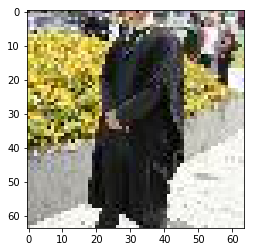

In [11]:
# check image is okay
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(x_train[0].astype(np.uint8))
plt.show()

In [12]:
# this one sucks

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(64,64,3)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='softmax'))
print(model.summary())

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_split=0.2)

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)              

In [ ]:
# from keras.applications import VGG16
# from keras import models
# from keras import layers
# from keras import utils

# conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# model = models.Sequential()
# model.add(conv_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation="relu"))
# model.add(layers.Dense(200, activation="softmax"))
# print(model.summary())

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(x_train, utils.to_categorical(y_train, num_classes=200), batch_size=64, epochs=20, validation_split=0.2, shuffle=True)

In [20]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.optimizers import Adam

left_input = Input((64, 64, 3))
right_input = Input((64, 64, 3))

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(200, activation="softmax"))

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

model = siamese_net

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)